In [4]:
import torchvision

In [7]:
import os
import zipfile
output_dir = '/home/Dataset'
os.makedirs(output_dir, exist_ok=True)

# 打開壓縮文件並解壓縮
with zipfile.ZipFile('/home/images.zip', 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
class Resnet34_baseline(nn.Module):
    def __init__(self,class_num):
        super(Resnet34_baseline, self).__init__()

        self.Resnet34 = torchvision.models.resnet34()
        self.relu = nn.ReLU()
        self.linear = nn.Linear(1000,class_num)

        # 自訂義卷積核

    def forward(self, x):
        # 使用自訂義卷積核進行卷積運算
        x = self.Resnet34(x)
        x = self.relu(x)
        x = self.linear(x)
        return x

[1718426094.585138] [a68ecfb3fe5e:1428077:f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device


In [7]:
from torchinfo import summary
model = Resnet34_baseline(50)
batch_size = 1
summary(model, input_size=(batch_size, 3, 128, 128))

Layer (type:depth-idx)                        Output Shape              Param #
Resnet34_baseline                             [1, 50]                   --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 64, 64]           9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 64, 64]           128
│    └─ReLU: 2-3                              [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           --
│    └─Sequential: 2-5                        [1, 64, 32, 32]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 32, 32]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 32, 32]           73,984
│    │    └─BasicBlock: 3-3                   [1, 64, 32, 32]           73,984
│    └─Sequential: 2-6                        [1, 128, 16, 16]          --
│    │    └─BasicBlock: 3-4                   [1, 128, 16, 16]          230,144

In [21]:
def get_path_and_label(path):
  image_list = []
  label_list = []

  with open(path , 'r') as file:
    for line in file :
      text_list = line.split(' ')
      file_path = os.path.join('/home/Dataset',text_list[0])
      label = int(text_list[1])

      image_list.append(file_path)
      label_list.append(label)

  return image_list , label_list

In [22]:
train_txt_path = '/home/Dataset/train.txt'
test_txt_path = '/home/Dataset/test.txt'
val_txt_path = '/home/Dataset/val.txt'

train_img , train_label = get_path_and_label(train_txt_path)
test_img , test_label = get_path_and_label(test_txt_path)
val_img , val_label = get_path_and_label(val_txt_path)

print(f"Len of train_img {len(train_img)} ")
print(f"Len of train_label {len(train_label)}")

print(f"Len of val_img {len(val_img)}")
print(f"Len of val_label {len(val_label)}")

print(f"Len of test_img {len(test_img)}")
print(f"Len of test_label {len(test_label)}")

Len of train_img 63325 
Len of train_label 63325
Len of val_img 450
Len of val_label 450
Len of test_img 450
Len of test_label 450


In [23]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms

In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, img_path_list , img_label_list , transform=None, target_transform=None):
        self.img_path_list = img_path_list
        self.img_label_list  = img_label_list
        self.transform = transforms.Compose([transforms.Resize(size=((128,128)))])

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        image = read_image(self.img_path_list[idx])
        image = self.transform(image)
        if image.shape[0] == 1 :
          image = image.repeat(3,1,1)
        image = image.float() / 255.0
        label = self.img_label_list[idx]

        return image, label

In [25]:
train_dataset = CustomImageDataset(train_img , train_label )
val_dataset = CustomImageDataset(val_img , val_label)
test_dataset = CustomImageDataset(test_img , test_label )

In [26]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size = BATCH_SIZE , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
import torch.optim as optim
model = Resnet34_baseline(50)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [29]:
def calculate_accuracy(output, labels):

    preds = torch.argmax(output, dim=1)

    correct = torch.eq(preds, labels).sum().item()

    total = preds.shape[0]

    return correct , total

  0%|          | 0/495 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 4/4 [00:00<00:00,  9.15it/s]


Epoch 0 training loss 0.02540738384383872 val loss 0.027132532861497666
Epoch 0 training accuracy 0.12590604026845637 val accuracy 0.16


100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


Epoch 1 training loss 0.021787077150371204 val loss 0.024418367279900446
Epoch 1 training accuracy 0.21525463876825898 val accuracy 0.18222222222222223


100%|██████████| 4/4 [00:00<00:00,  9.34it/s]


Epoch 2 training loss 0.019272250449568023 val loss 0.02721558094024658
Epoch 2 training accuracy 0.28773786024476905 val accuracy 0.23333333333333334


100%|██████████| 4/4 [00:00<00:00,  9.40it/s]


Epoch 3 training loss 0.017076652032134564 val loss 0.020587658882141112
Epoch 3 training accuracy 0.3570311883142519 val accuracy 0.33111111111111113


100%|██████████| 4/4 [00:00<00:00,  9.78it/s]


Epoch 4 training loss 0.015154774747156504 val loss 0.020677466922336154
Epoch 4 training accuracy 0.41975523095144096 val accuracy 0.35555555555555557


100%|██████████| 4/4 [00:00<00:00, 10.44it/s]


Epoch 5 training loss 0.013442044719330087 val loss 0.017374400032891167
Epoch 5 training accuracy 0.4760363205684959 val accuracy 0.43333333333333335


100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch 6 training loss 0.011766101654179238 val loss 0.016512090630001492
Epoch 6 training accuracy 0.5322858270825108 val accuracy 0.44222222222222224


100%|██████████| 4/4 [00:00<00:00,  9.54it/s]


Epoch 7 training loss 0.010262539878081673 val loss 0.016186258792877196
Epoch 7 training accuracy 0.583987366758784 val accuracy 0.4777777777777778


100%|██████████| 4/4 [00:00<00:00,  9.35it/s]


Epoch 8 training loss 0.008737947956827663 val loss 0.020012485716078016
Epoch 8 training accuracy 0.6406158705092775 val accuracy 0.4288888888888889


100%|██████████| 4/4 [00:00<00:00,  9.48it/s]


Epoch 9 training loss 0.007255000597490325 val loss 0.019701882468329535
Epoch 9 training accuracy 0.6922068693249112 val accuracy 0.4311111111111111


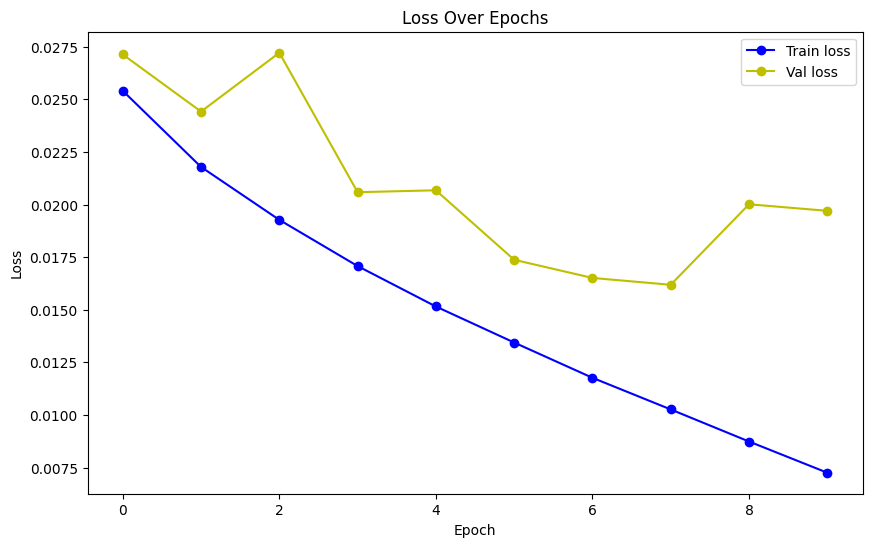

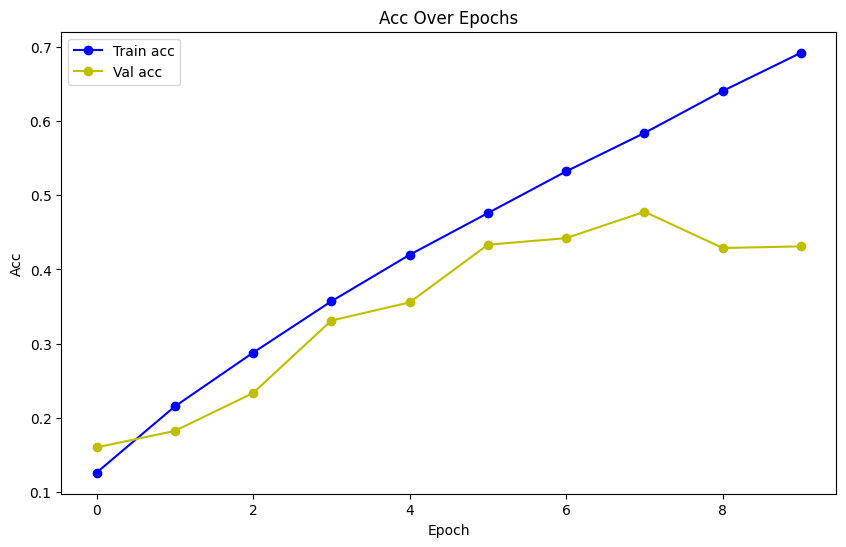

In [30]:
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCH = 10
training_loss_list = []
val_loss_list = []
training_accuracy_list = []
val_accuracy_list = []

for epoch in range(EPOCH) :
  training_loss = 0.0
  training_total_num = 0
  training_correct_num = 0
  val_loss = 0.0
  val_total_num = 0
  val_correct_num = 0
  model.train()
  for data in tqdm(train_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    optimizer.zero_grad()

    outputs = model(img)
    #print(outputs[0])
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    training_correct_num += correct_num
    training_total_num += count

  model.eval()
  for data in tqdm(val_dataloader) :
    img , label = data
    img = img.to(device)
    label = label.to(device)
    outputs = model(img)
    loss = criterion(outputs, label)
    val_loss += loss.item()
    correct_num , count  = calculate_accuracy(outputs,label)
    val_correct_num += correct_num
    val_total_num += count

  training_loss = training_loss/training_total_num
  val_loss = val_loss/val_total_num
  training_accuracy = training_correct_num/training_total_num
  val_accuracy = val_correct_num/val_total_num
  print(f"Epoch {epoch} training loss {training_loss} val loss {val_loss}")
  print(f"Epoch {epoch} training accuracy {training_accuracy} val accuracy {val_accuracy}")
  training_loss_list.append(training_loss)
  training_accuracy_list.append(training_accuracy)
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(training_loss_list, marker='o', linestyle='-', color='b' , label = 'Train loss')
plt.plot(val_loss_list, marker='o', linestyle='-', color='y', label = 'Val loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(training_accuracy_list, marker='o', linestyle='-', color='b' , label = 'Train acc')
plt.plot(val_accuracy_list, marker='o', linestyle='-', color='y', label = 'Val acc')
plt.title('Acc Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [31]:
test_loss = 0.0
test_correct_num = 0
test_total_num = 0
model.eval()
for data in tqdm(test_dataloader) :
  img , label = data
  img = img.to(device)
  label = label.to(device)
  optimizer.zero_grad()

  outputs = model(img)
  #print(outputs[0])
  loss = criterion(outputs, label)
  #loss.backward()
  #optimizer.step()
  test_loss += loss.item()
  correct_num , count  = calculate_accuracy(outputs,label)
  test_correct_num += correct_num
  test_total_num += count

test_loss = test_loss/test_total_num
test_accuracy = test_correct_num/test_total_num
print(f"Test loss {test_loss} test accuracy {test_accuracy}")

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

Test loss 0.018060671753353543 test accuracy 0.45111111111111113
